# Data Cleaning

## Outline
0. Load and join dataframes
1. Handle missing values
   - Identify columns with missing data
   - Decide on appropriate strategies for each column
   - Impute or handle missing values as needed
2. Convert data types
   - Change 'start_date' to datetime format
   - Convert 'home_line_scores' and 'away_line_scores' to usable format
3. Handle outliers
   - Check for and address unrealistic values in numerical columns
4. Create derived features
   - Calculate point difference
   - Generate 'winner' column
   - Create time-based features from 'start_date'
5. Review and validate cleaned dataset

## Load Packages & Data

In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os
import sqlite3
import pandas as pd

# Add the project root to the Python path
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
project_root = os.path.dirname(notebook_dir)
sys.path.append(project_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.data.cleaning import (
    merge_and_clean_dataframes,
    clean_dataframe,
    generate_and_save_team_pairs,
    deduplicate_dataframes
)
from src.visualization.distribution_plots import (
    analyze_distribution,
    visualize_null_values,
    plot_mean_over_time,
    plot_null_frequency_by_season,
    plot_zero_values_by_year
)

In [2]:
# Load the games data from the parquet file
games_df = pd.read_parquet('../data/01_raw/games.parquet')

# Load the advanced team game stats from the parquet file
advanced_stats_df = pd.read_parquet('../data/01_raw/advanced_team_game_stats.parquet')

# Load the team game stats from the parquet file
team_stats_df = pd.read_parquet('../data/01_raw/team_game_stats.parquet')

# Load the team talent data from the parquet file
team_talent_df = pd.read_parquet('../data/01_raw/team_talent.parquet')

In [127]:
def load_data_from_db(db_path):
    conn = sqlite3.connect(db_path)
    
    advanced_stats_df = pd.read_sql("SELECT * FROM advanced_team_game_stats", conn)
    betting_df = pd.read_sql("SELECT * FROM betting_lines", conn)
    elo_df = pd.read_sql("SELECT * FROM elo_ratings", conn)
    fpi_df = pd.read_sql("SELECT * FROM fpi_ratings", conn)
    games_df = pd.read_sql("SELECT * FROM games", conn)
    probabilities_df = pd.read_sql("SELECT * FROM pregame_win_probabilities", conn)
    sp_df = pd.read_sql("SELECT * FROM sp_ratings", conn)
    srs_df = pd.read_sql("SELECT * FROM srs_ratings", conn)
    team_stats_df = pd.read_sql("SELECT * FROM team_game_stats", conn)
    recruiting_df = pd.read_sql("SELECT * FROM team_recruiting", conn)
    team_talent_df = pd.read_sql("SELECT * FROM team_talent", conn)
    
    conn.close()
    
    return (
        advanced_stats_df,
        betting_df,
        elo_df,
        fpi_df,
        games_df,
        probabilities_df,
        sp_df,
        srs_df,
        team_stats_df,
        recruiting_df,
        team_talent_df
    )

# Usage
db_path = '../data/02_interim/college_football.db'

(advanced_stats_df, betting_df, elo_df,
 fpi_df, games_df, probabilities_df,
 sp_df, srs_df, team_stats_df,
 recruiting_df, team_talent_df) = load_data_from_db(db_path)

In [10]:
# Count number of rows in games_df where id does not exist in team_stats_df.game_id
missing_games = games_df[~games_df['id'].isin(team_stats_df['id'])]
missing_count = len(missing_games)

# Calculate the percentage
total_games = len(games_df)
missing_percentage = (missing_count / total_games) * 100

print(f"Number of games missing from team_stats_df: {missing_count}")
print(f"Percentage of games missing: {missing_percentage:.2f}%")

# Optional: Display some information about the missing games
print("\nSample of missing games:")
print(missing_games[['id', 'season', 'week', 'home_team', 'away_team']].head())


Number of games missing from team_stats_df: 2387
Percentage of games missing: 21.26%

Sample of missing games:
          id season week   home_team         away_team
0  212420008   2001    2    Arkansas              UNLV
1  212420238   2001    2  Vanderbilt  Middle Tennessee
2  212440096   2001    2    Kentucky        Louisville
3  212440061   2001    2     Georgia    Arkansas State
4  212442633   2001    2   Tennessee          Syracuse


## Cleaning summary

1. Build Transformed Teams db

-   Goal is to build on team_stats_df
-   Checking for duplicates:
    -   found in games_df, team_stats_df, and team_talent_df
    -   **Drop duplicates**
-   **Drop duplicates in team_game_stats**
    -   Drop points column
-   **LEFT JOIN advanced_team_game_stats**
    -   on as.game_id == tgs.id AND as.team == tgs.school
    -   drop season, week, and team columns, keep the rest
-   **LEFT JOIN betting_lines** --> needs to join on both matches
    -   on id
    -   *do we switch sign based on home_away?**
    -   average(line_spread) as avg_line_spread --> this will ignore nulls and return null if null?
    -   average(line_spread_open) as avg_line_spread_open
    -   average(line_over_under) as avg_line_over_under
    -   average(line_over_under_open) as avg_line_over_under_open
    -   average(line_home_moneyline) as avg_line_home_moneyline
    -   average(line_away_moneyline) as avg_line_away_moneyline
-   **LEFT JOIN games**
    -   on id = id
    -   season, week, season_type, start_date, completed
    -   neutral_site, conference_game, attendance, venue_id
    -   venue,
    -   *make these conditional on home_away, team vs opponent*
        -   home_points, home_line_scores
        -   home_pregame_elo, home_postgame_elo, 
        -   away_points, away_line_scores
        -   away_pregame_elo, home_postgame_elo
        -   home_id, away_id
    -   excitement_index
-   **LEFT JOIN elo_ratings**
    -   on er.year = games.season AND er.team = tgs.school(?)
    -   elo as elo_year
-   **fpi_ratings appear to be updated live... so not using**
    -   Same with sp_ratings
    -   same with srs_ratings


In [129]:
from src.data.create_transformed_teams import create_transformed_teams_db

source_db_path = '../data/02_interim/college_football.db'
target_db_path = '../data/02_interim/transformed_teams.db'

create_transformed_teams_db(source_db_path, target_db_path)

Transformed teams data has been written to ../data/02_interim/transformed_teams.db


In [51]:
from src.data.create_transformed_teams import load_transformed_teams_df

# Assuming you're in the project root directory
target_db_path = '../data/02_interim/transformed_teams.db'
transformed_teams_df = load_transformed_teams_df(target_db_path)

# Now you can work with the transformed_teams_df
print(transformed_teams_df.shape)

(20750, 137)


In [126]:
print(transformed_teams_df.dtypes.to_string())

id                                        int64
year                                      int64
week                                      int64
season_type                              object
start_date                               object
completed                                 int64
neutral_site                              int64
conference_game                          object
attendance                              float64
venue_id                                float64
venue                                    object
team                                     object
opponent                                 object
team_conference                          object
opponent_conference                      object
team_division                            object
opponent_division                        object
team_points                             float64
opponent_points                         float64
team_line_scores                         object
opponent_line_scores                    

In [14]:
def count_duplicates(df):
    """
    Count the number of duplicated rows in a DataFrame.
    
    Args:
    df (pandas.DataFrame): The DataFrame to check for duplicates.
    
    Returns:
    int: The number of duplicated rows.
    """
    num_duplicates = df.duplicated().sum()
    total_rows = len(df)
    duplicate_percentage = (num_duplicates / total_rows) * 100
    
    if num_duplicates > 0:
        print(f"Total rows: {total_rows}")
        print(f"Number of duplicated rows: {num_duplicates}")
        print(f"Percentage of duplicated rows: {duplicate_percentage:.2f}%")
    else:
        print("No duplicates found.")
    
    return num_duplicates

print("Checking for duplicates in advanced_stats_df:")
count_duplicates(advanced_stats_df)

print("\nChecking for duplicates in betting_df:")
count_duplicates(betting_df)

print("\nChecking for duplicates in elo_df:")
count_duplicates(elo_df)

print("\nChecking for duplicates in fpi_df:")
count_duplicates(fpi_df)

print("\nChecking for duplicates in games_df:")
count_duplicates(games_df)

print("\nChecking for duplicates in probabilities_df:")
count_duplicates(probabilities_df)

print("\nChecking for duplicates in sp_df:")
count_duplicates(sp_df)

print("\nChecking for duplicates in srs_df:")
count_duplicates(srs_df)

print("\nChecking for duplicates in team_stats_df:")
count_duplicates(team_stats_df)

print("\nChecking for duplicates in recruiting_df:")
count_duplicates(recruiting_df)

print("\nChecking for duplicates in team_talent_df:")
count_duplicates(team_talent_df)


Checking for duplicates in advanced_stats_df:
No duplicates found.

Checking for duplicates in betting_df:
No duplicates found.

Checking for duplicates in elo_df:
No duplicates found.

Checking for duplicates in fpi_df:
No duplicates found.

Checking for duplicates in games_df:
Total rows: 11230
Number of duplicated rows: 855
Percentage of duplicated rows: 7.61%

Checking for duplicates in probabilities_df:
No duplicates found.

Checking for duplicates in sp_df:
No duplicates found.

Checking for duplicates in srs_df:
No duplicates found.

Checking for duplicates in team_stats_df:
Total rows: 17686
Number of duplicated rows: 888
Percentage of duplicated rows: 5.02%

Checking for duplicates in recruiting_df:
No duplicates found.

Checking for duplicates in team_talent_df:
Total rows: 2144
Number of duplicated rows: 3
Percentage of duplicated rows: 0.14%


np.int64(3)

## Null team_stats_df

In [9]:
# Filter games_df to include only rows where the id exists in team_stats_df
initial_count = len(games_df)
games_df = games_df[games_df['id'].isin(team_stats_df['id'])]
filtered_count = len(games_df)

# Calculate the number and percentage of rows dropped
rows_dropped = initial_count - filtered_count
percentage_dropped = (rows_dropped / initial_count) * 100

print(f"Rows dropped: {rows_dropped}")
print(f"Percentage of rows dropped: {percentage_dropped:.2f}%")

Rows dropped: 2387
Percentage of rows dropped: 21.26%


## Check for Duplicates

In [47]:
# Check for duplicate 'id' and 'team' combinations
duplicate_id_team = transformed_teams_df.duplicated(subset=['id', 'team'])
num_duplicates = duplicate_id_team.sum()
total_rows = len(transformed_teams_df)
duplicate_percentage = (num_duplicates / total_rows) * 100

print(f"Number of duplicate 'id' and 'team' combinations: {num_duplicates}")
print(f"Percentage of duplicate 'id' and 'team' combinations: {duplicate_percentage:.2f}%")


Number of duplicate 'id' and 'team' combinations: 0
Percentage of duplicate 'id' and 'team' combinations: 0.00%


## Data Types

In [48]:
# Batch print data types for better readability
print("Data types of transformed_teams_df:")
for column, dtype in transformed_teams_df.dtypes.items():
    print(f"{column:<30} {dtype}")

Data types of transformed_teams_df:
id                             int64
year                           int64
week                           int64
season_type                    object
start_date                     object
completed                      int64
neutral_site                   int64
conference_game                object
attendance                     float64
venue_id                       float64
venue                          object
team                           object
opponent                       object
team_conference                object
opponent_conference            object
team_division                  object
opponent_division              object
team_points                    float64
opponent_points                float64
team_line_scores               object
opponent_line_scores           object
team_post_win_prob             float64
opponent_post_win_prob         float64
excitement_index               float64
team_pregame_elo               float64
opponent_pr

## Handle Missing Values

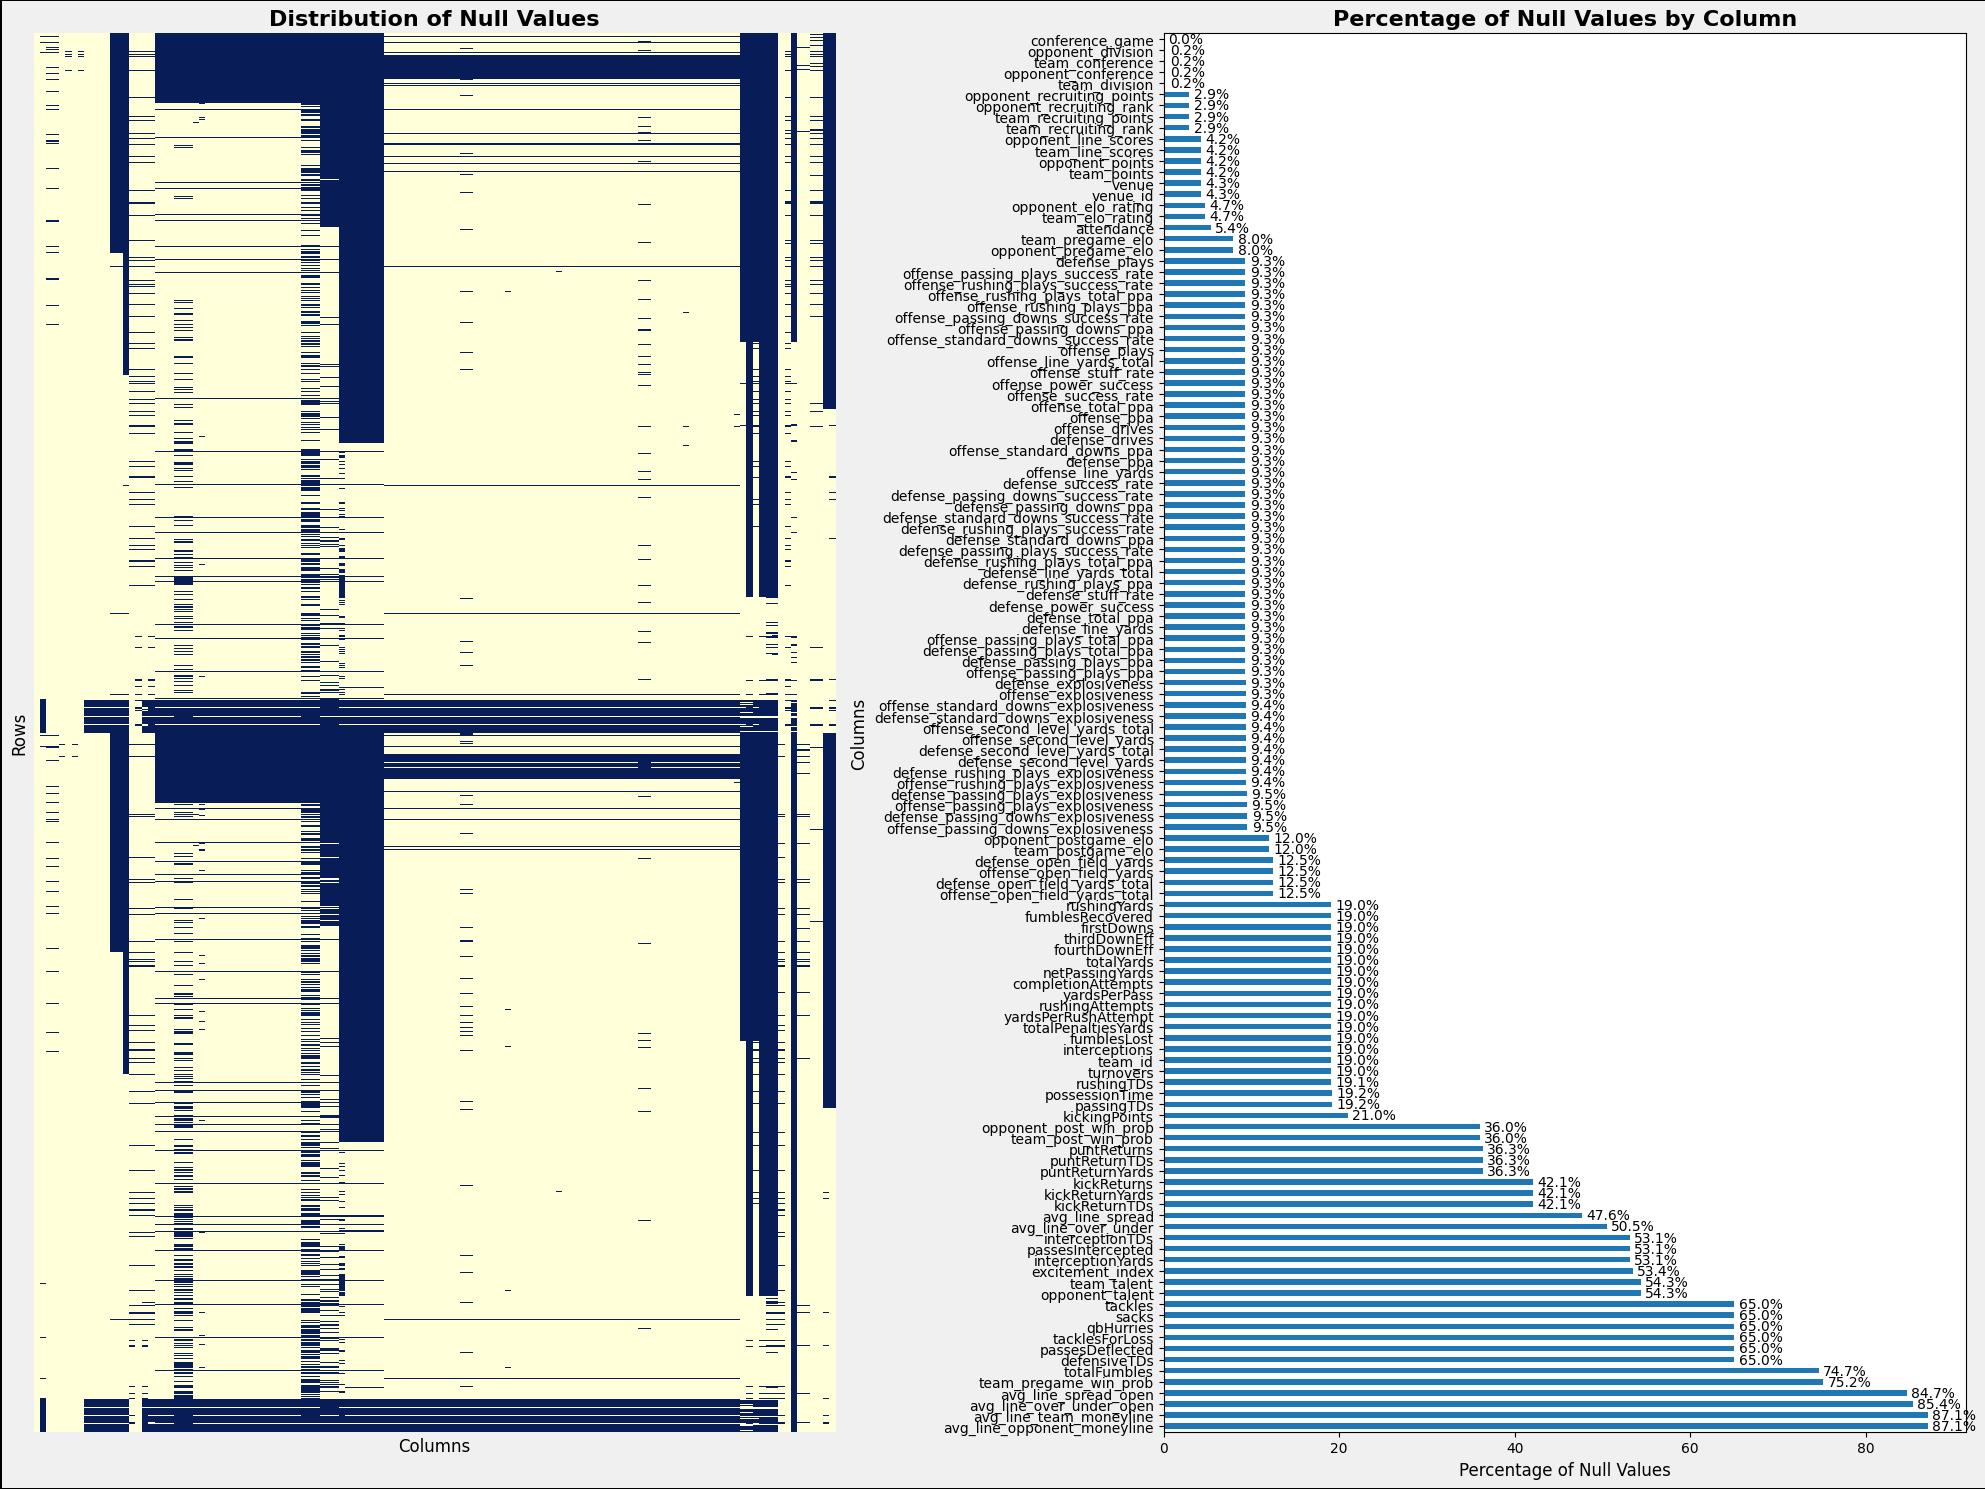

Columns with null values (sorted by percentage, descending):
avg_line_opponent_moneyline: 18063 null values (87.05%)
avg_line_team_moneyline: 18063 null values (87.05%)
avg_line_over_under_open: 17712 null values (85.36%)
avg_line_spread_open: 17572 null values (84.68%)
team_pregame_win_prob: 15595 null values (75.16%)
totalFumbles: 15496 null values (74.68%)
defensiveTDs: 13494 null values (65.03%)
passesDeflected: 13494 null values (65.03%)
tacklesForLoss: 13494 null values (65.03%)
qbHurries: 13494 null values (65.03%)
sacks: 13494 null values (65.03%)
tackles: 13494 null values (65.03%)
opponent_talent: 11277 null values (54.35%)
team_talent: 11277 null values (54.35%)
excitement_index: 11090 null values (53.45%)
interceptionYards: 11022 null values (53.12%)
passesIntercepted: 11022 null values (53.12%)
interceptionTDs: 11022 null values (53.12%)
avg_line_over_under: 10474 null values (50.48%)
avg_line_spread: 9884 null values (47.63%)
kickReturnTDs: 8738 null values (42.11%)
kickR

In [84]:
visualize_null_values(transformed_teams_df)

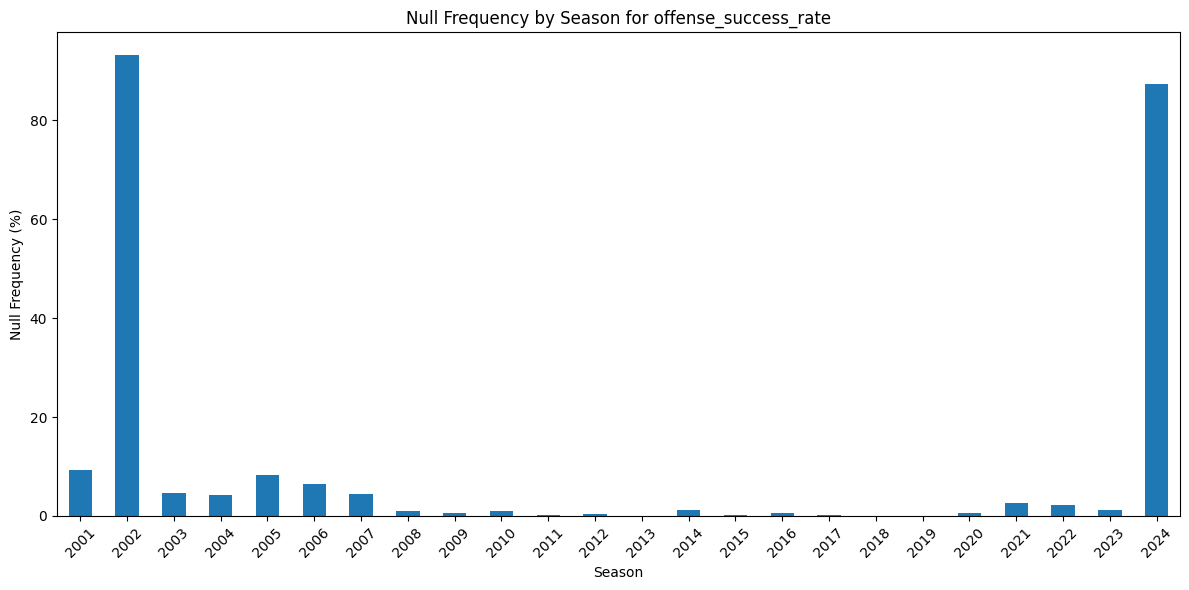

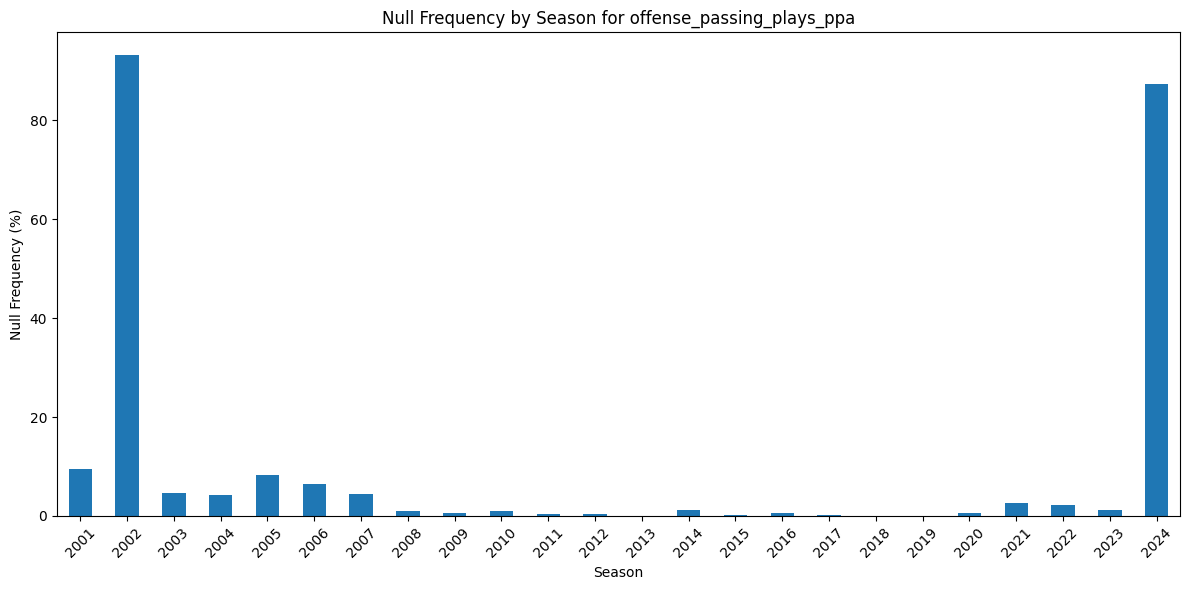

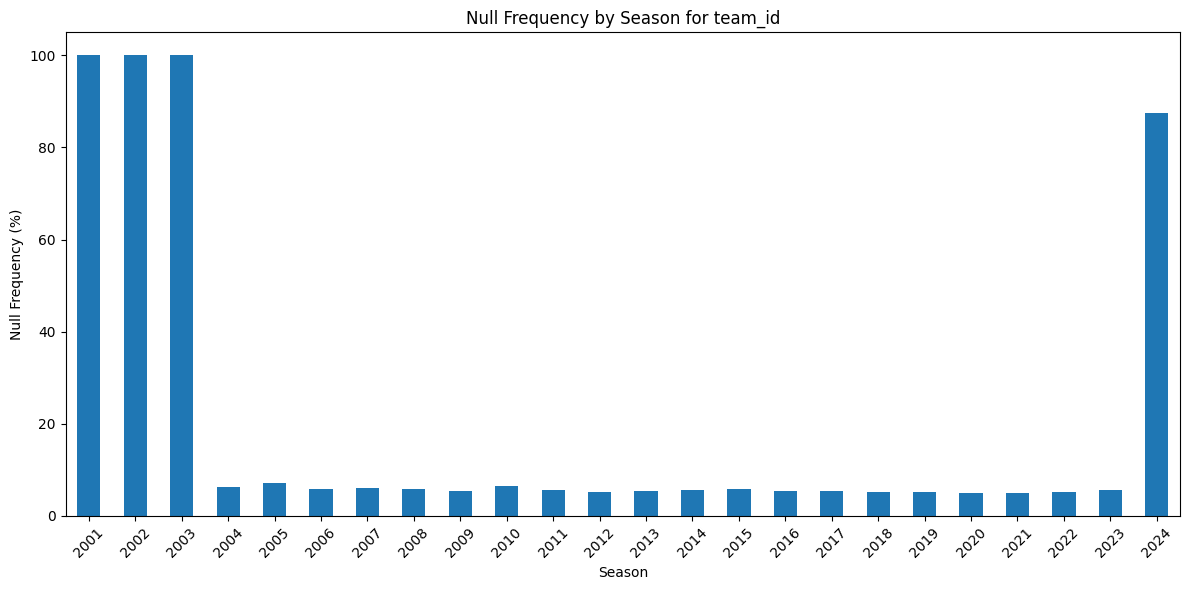

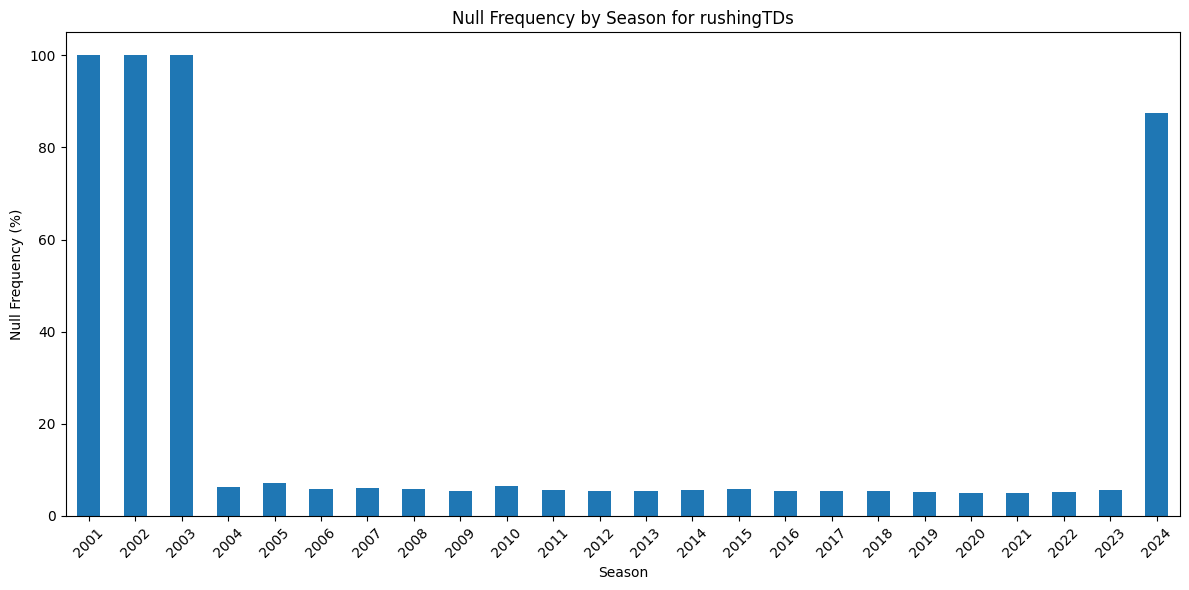

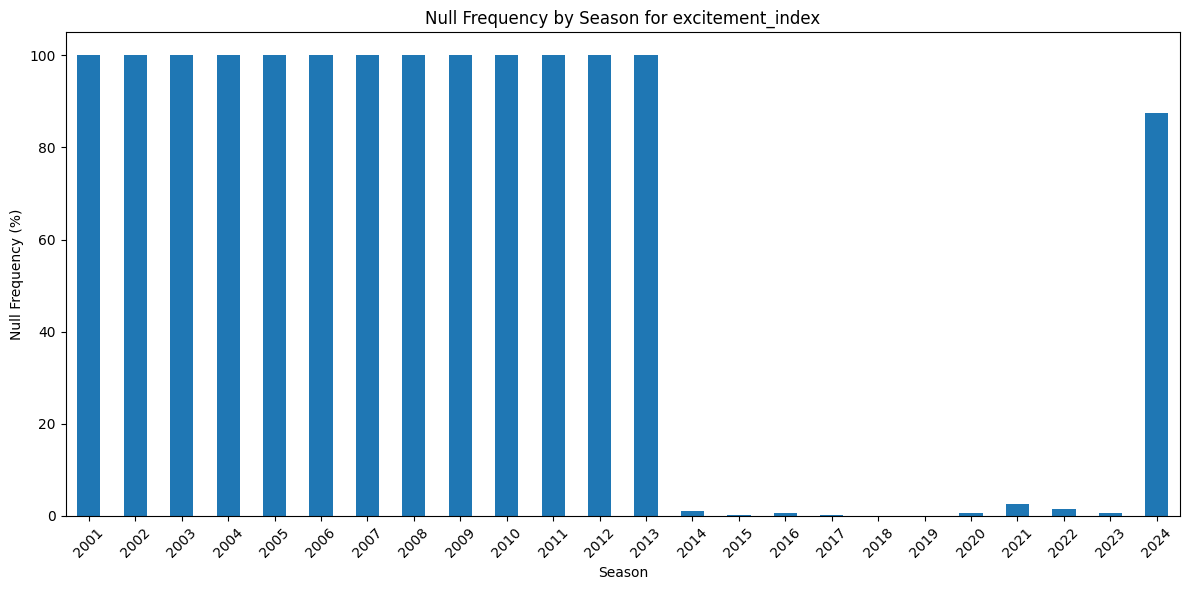

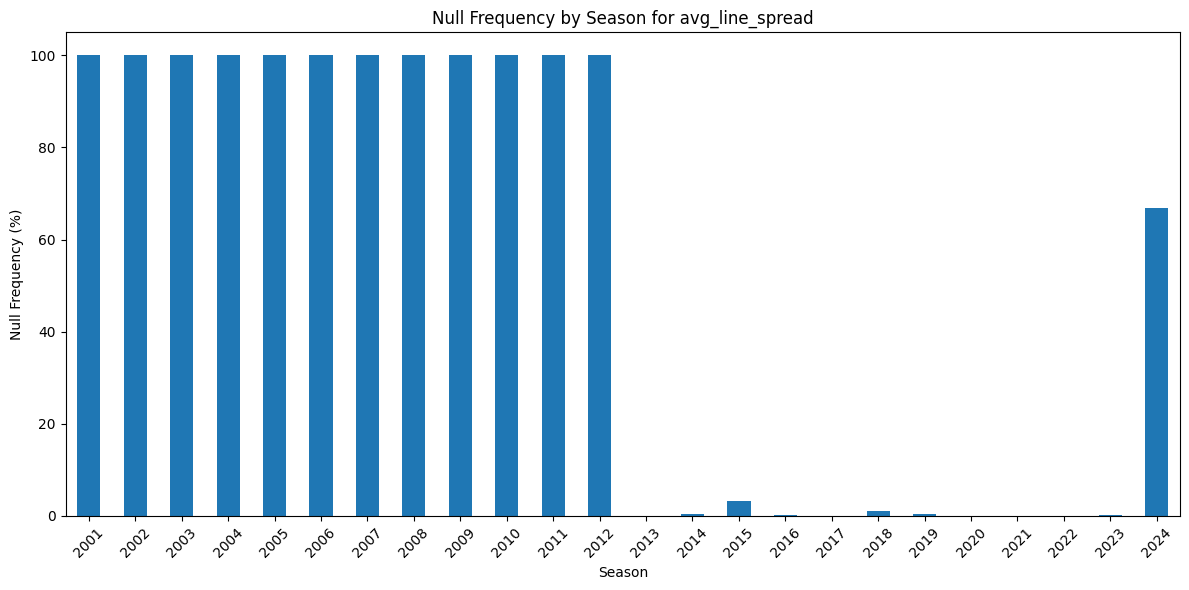

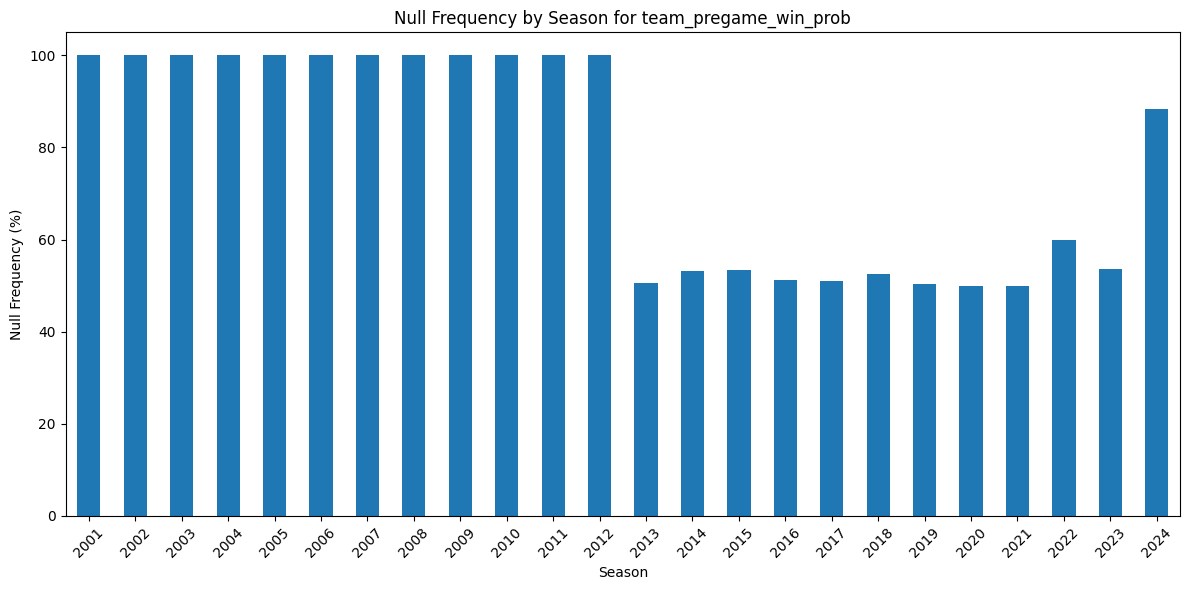

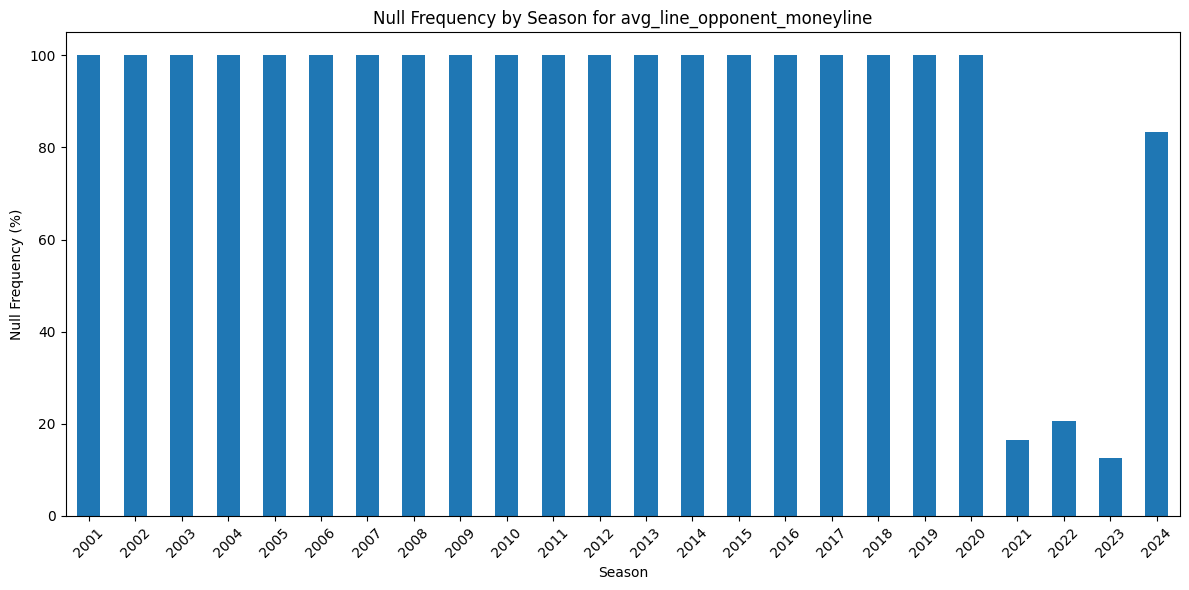

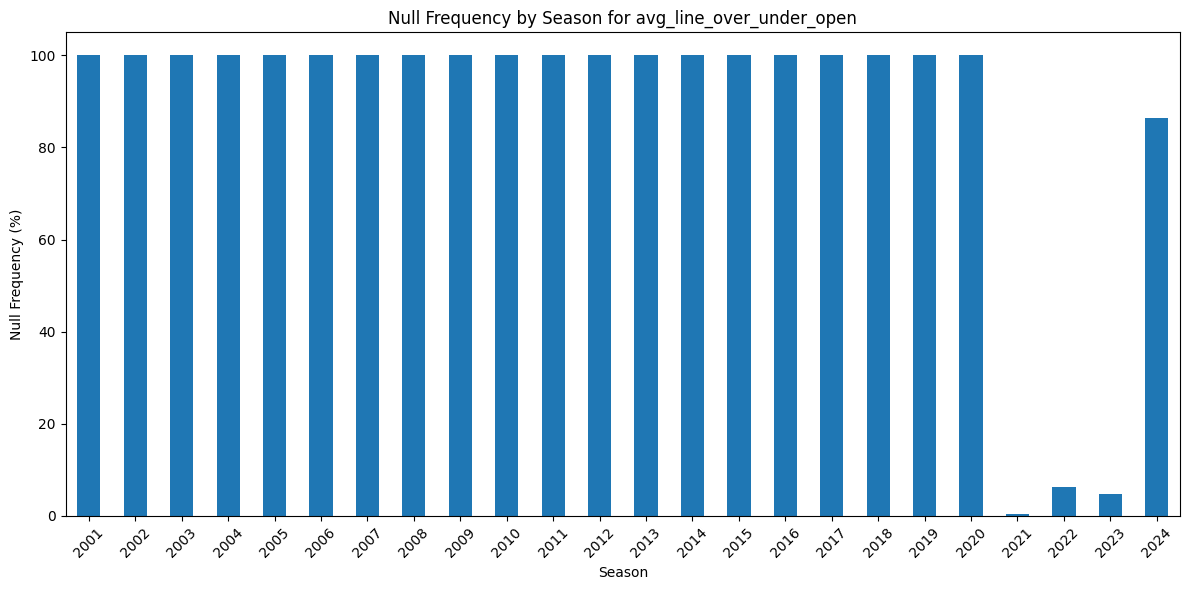

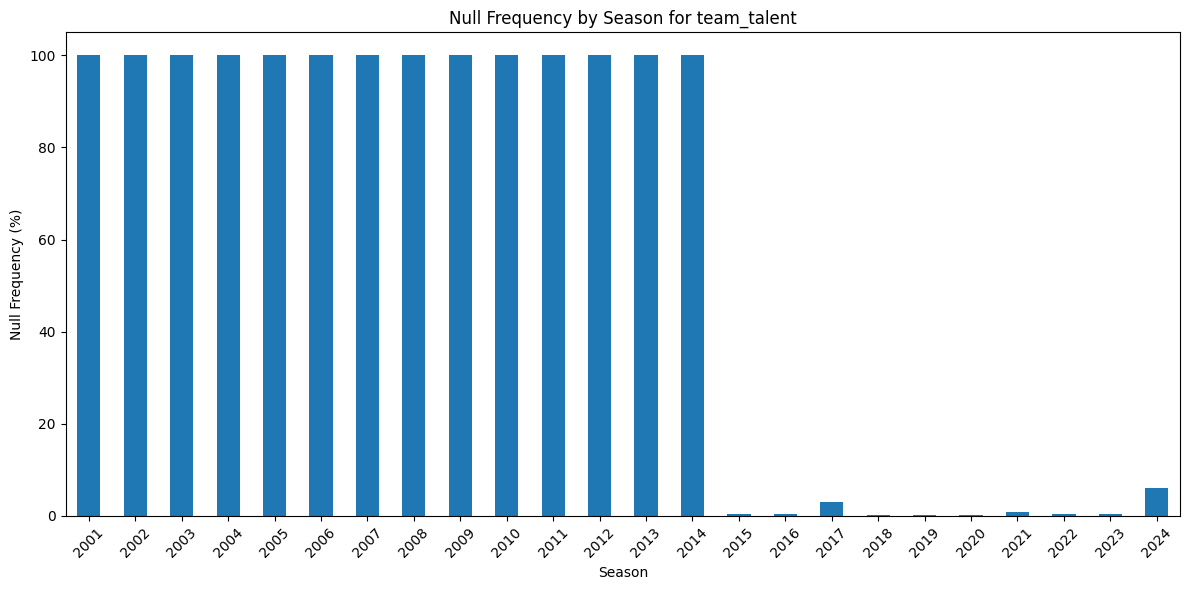

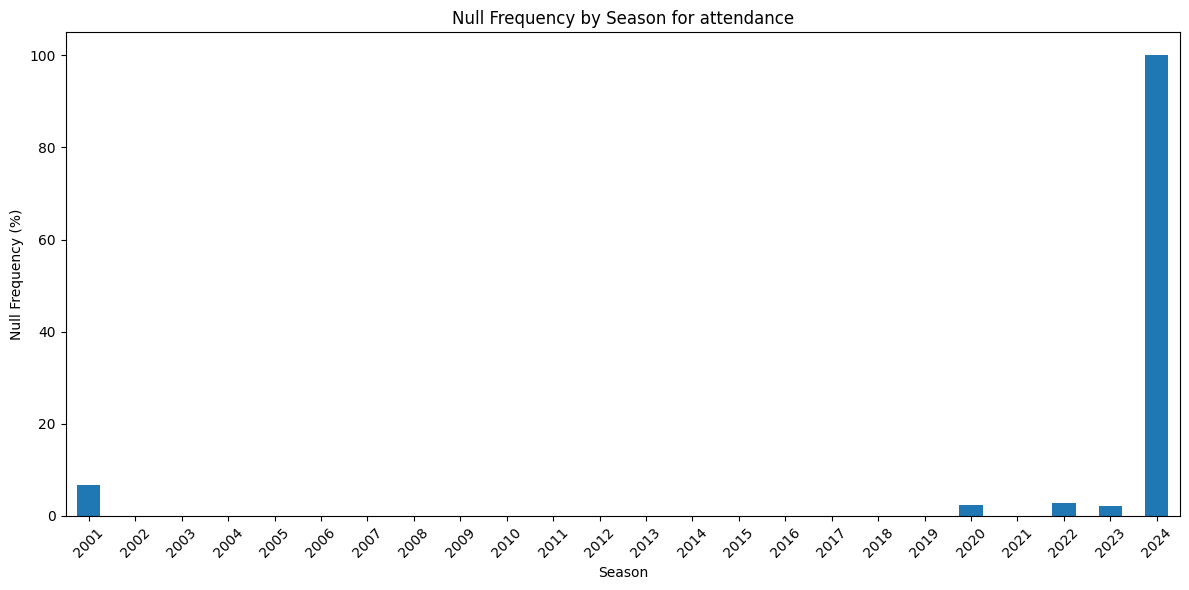

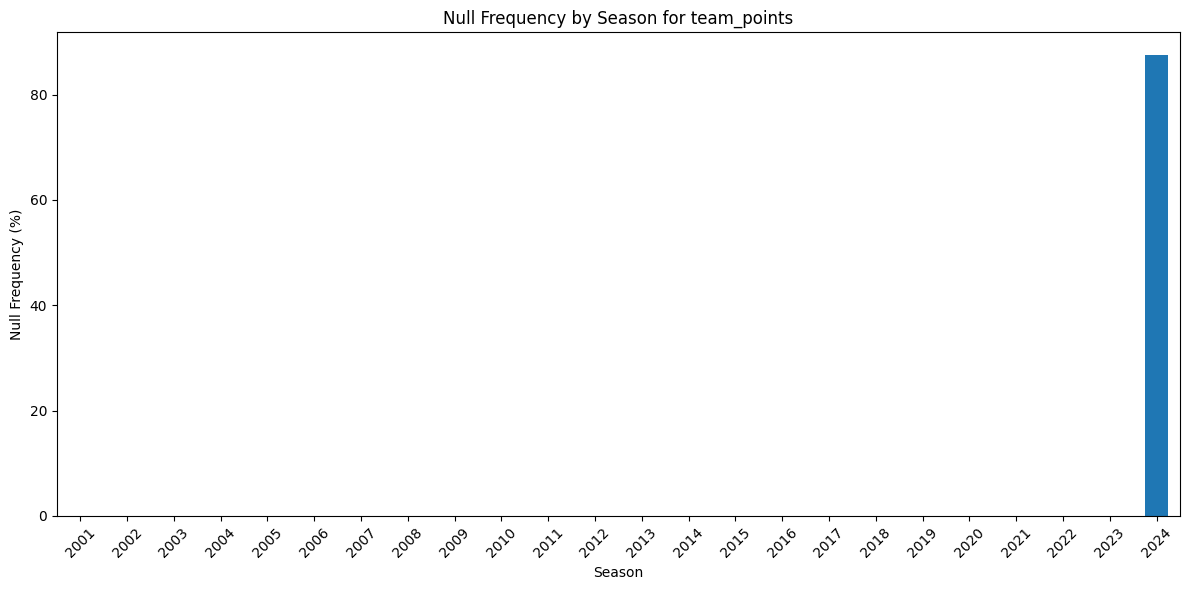

In [148]:
plot_null_frequency_by_season(transformed_teams_df, [
    'offense_success_rate',
    'offense_passing_plays_ppa',
    'team_id',
    'rushingTDs',
    'excitement_index',
    'avg_line_spread',
    'team_pregame_win_prob',
    'avg_line_opponent_moneyline',
    'avg_line_over_under_open',
    'team_talent',
    'attendance',
    'team_points'
])

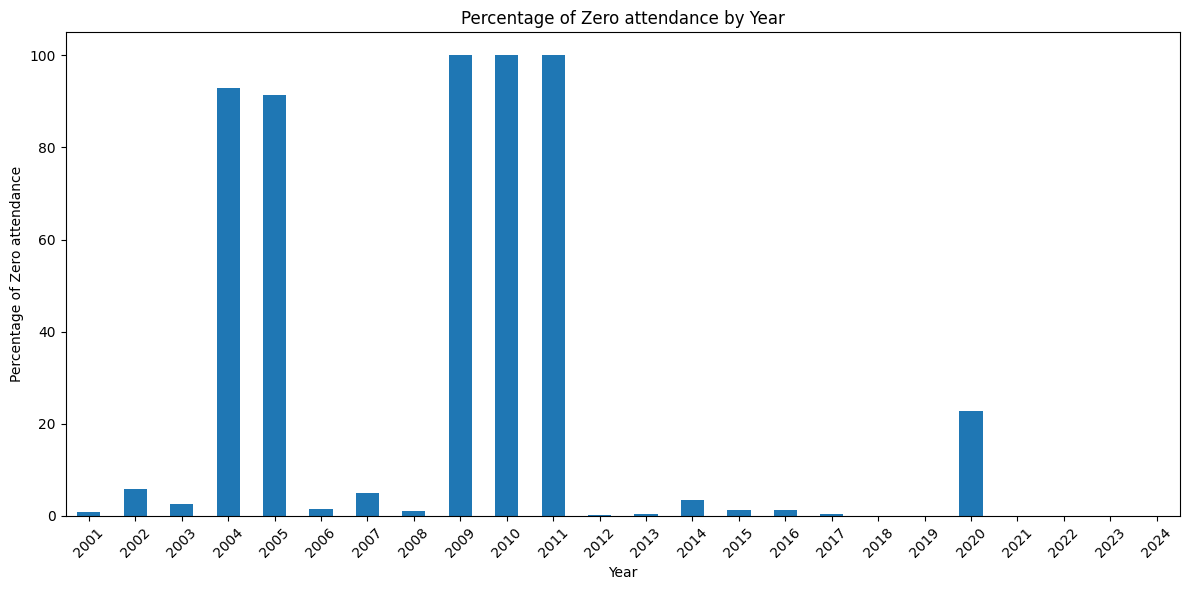

In [54]:
plot_zero_values_by_year(transformed_teams_df, 'attendance')

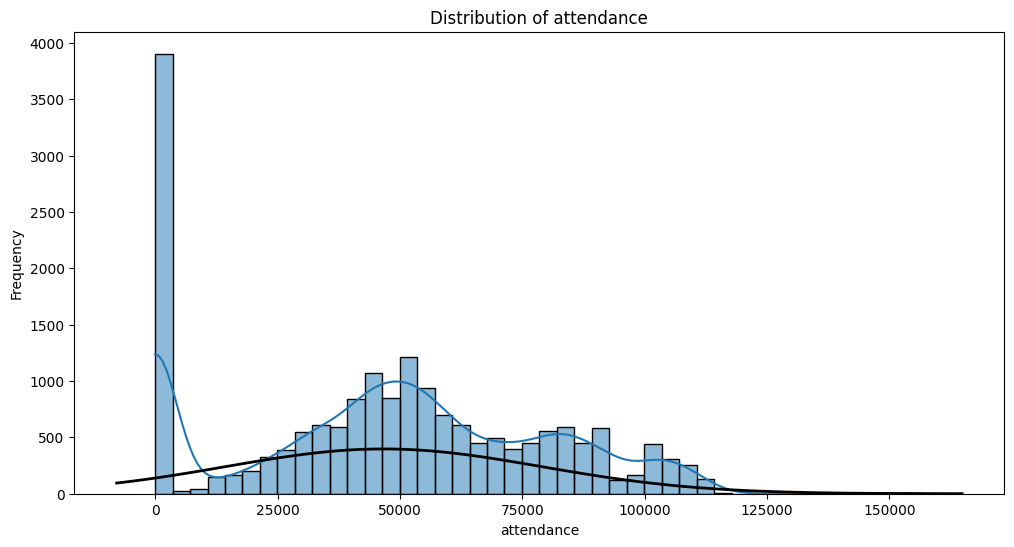

Shapiro-Wilk test - statistic: 0.9423, p-value: 0.0000
Skewness: 0.0227
Kurtosis: -0.9192


/Users/colingaffney/repos/personal-projects/college_football_predictor/venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 18564.
  res = hypotest_fun_out(*samples, **kwds)


In [30]:
analyze_distribution(df, 'attendance')

In [169]:
# Apply the cleaning function
cleaned_df = clean_dataframe(df)

# Check how many rows were removed
print(f"Rows before cleaning: {len(df)}")
print(f"Rows after cleaning: {len(cleaned_df)}")
print(f"Rows removed: {len(df) - len(cleaned_df)}")

Rows before cleaning: 16708
Rows after cleaning: 16438
Rows removed: 270


In [166]:
from src.data.create_processed_teams import create_processed_teams_db, load_processed_teams_df

# Define the paths (adjust these as needed for your notebook's location)
source_db_path = '../data/02_interim/transformed_teams.db'
target_db_path = '../data/03_processed/processed_teams.db'

# Create the processed teams database
create_processed_teams_db(source_db_path, target_db_path)

# Load the processed teams data into a DataFrame
processed_teams_df = load_processed_teams_df(target_db_path)

# Now you can work with the processed_teams_df
print(processed_teams_df.shape)

Source DB path: ../data/02_interim/transformed_teams.db
Target DB path: ../data/03_processed/processed_teams.db
Processed teams data has been written to ../data/03_processed/processed_teams.db
(20750, 139)


In [167]:
from src.data.create_processed_teams import load_processed_teams_df

# Assuming you're in the project root directory
target_db_path = '../data/03_processed/processed_teams.db'
processed_teams_df = load_processed_teams_df(target_db_path)

# Now you can work with the transformed_teams_df
print(processed_teams_df.shape)

(20750, 139)


In [168]:
import pandas as pd
import numpy as np

# Assuming 'year' column exists in processed_teams_df
# If not, you might need to extract it from 'start_date' or another relevant column

temp = processed_teams_df[processed_teams_df['year'] < 2024]

# Function to calculate null percentage for a column in a given year
def null_percentage(df, column, year):
    year_data = df[df['year'] == year][column]
    return (year_data.isnull().sum() / len(year_data)) * 100 if not year_data.empty else np.nan

# Get all columns except 'year'
columns = [col for col in temp.columns if col != 'year']

# Get unique years
years = temp['year'].unique()

# Calculate null percentages for each column and year
null_percentages = {col: {year: null_percentage(temp, col, year) for year in years} for col in columns}

# Convert to DataFrame for easier analysis
null_df = pd.DataFrame(null_percentages)

# Function to find years with non-null values for each column
def years_with_non_nulls(series):
    return [year for year, value in series.items() if not pd.isnull(value) and value < 100]

# Calculate highest null percentage for each column in years with non-nulls
highest_nulls = {}
for col in null_df.columns:
    non_null_years = years_with_non_nulls(null_df[col])
    if non_null_years:
        highest_null = null_df.loc[non_null_years, col].max()
        highest_nulls[col] = highest_null

# Sort columns by highest null percentage
sorted_columns = sorted(highest_nulls.items(), key=lambda x: x[1], reverse=True)

# Print results
print("Columns with highest % of nulls in years where they have non-nulls:")
for col, percentage in sorted_columns:
    print(f"{col}: {percentage:.2f}%")


Columns with highest % of nulls in years where they have non-nulls:
kickReturnYards: 97.36%
kickReturnTDs: 97.36%
kickReturns: 97.36%
offense_open_field_yards: 93.84%
offense_open_field_yards_total: 93.84%
defense_open_field_yards: 93.84%
defense_open_field_yards_total: 93.84%
offense_plays: 93.15%
offense_drives: 93.15%
offense_ppa: 93.15%
offense_total_ppa: 93.15%
offense_success_rate: 93.15%
offense_explosiveness: 93.15%
offense_power_success: 93.15%
offense_stuff_rate: 93.15%
offense_line_yards: 93.15%
offense_line_yards_total: 93.15%
offense_second_level_yards: 93.15%
offense_second_level_yards_total: 93.15%
offense_standard_downs_ppa: 93.15%
offense_standard_downs_success_rate: 93.15%
offense_standard_downs_explosiveness: 93.15%
offense_passing_downs_ppa: 93.15%
offense_passing_downs_success_rate: 93.15%
offense_passing_downs_explosiveness: 93.15%
offense_rushing_plays_ppa: 93.15%
offense_rushing_plays_total_ppa: 93.15%
offense_rushing_plays_success_rate: 93.15%
offense_rushing_p

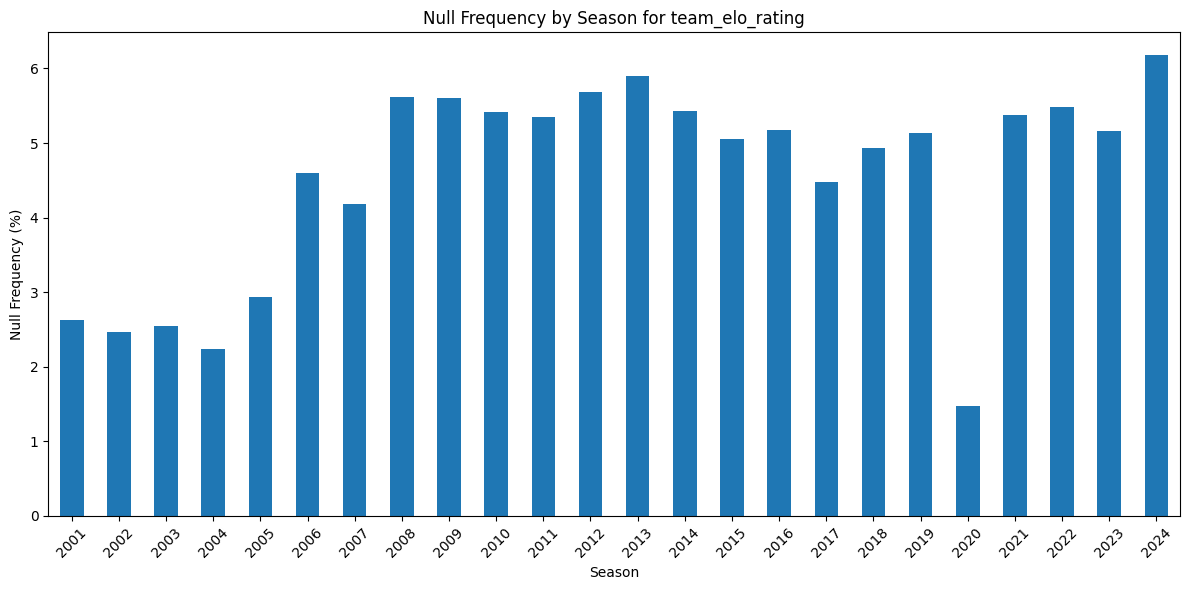

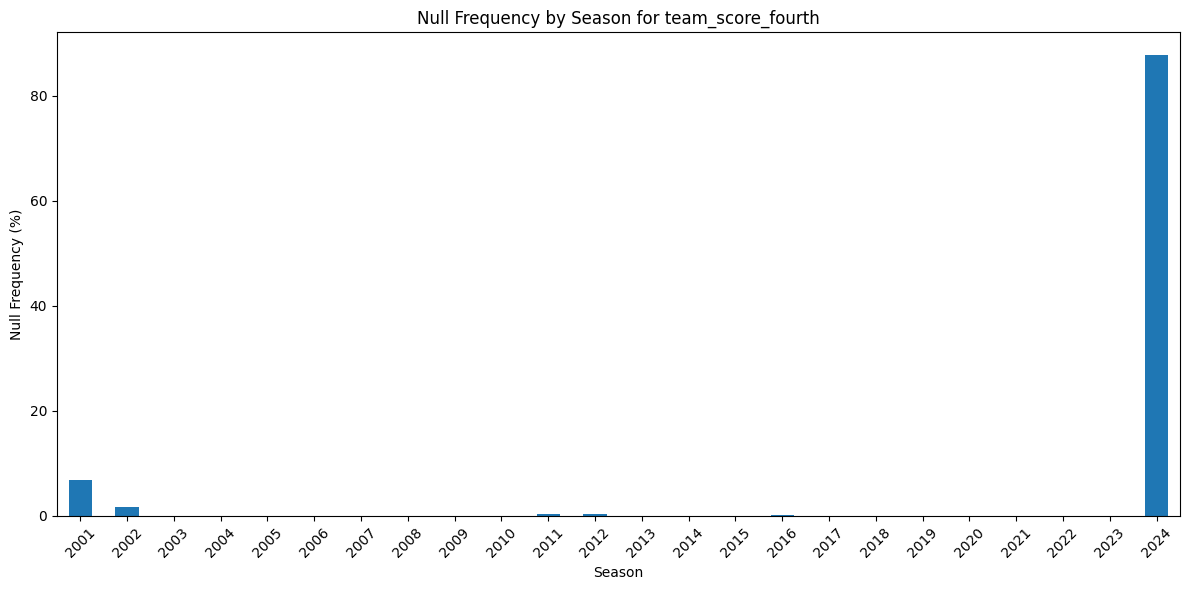

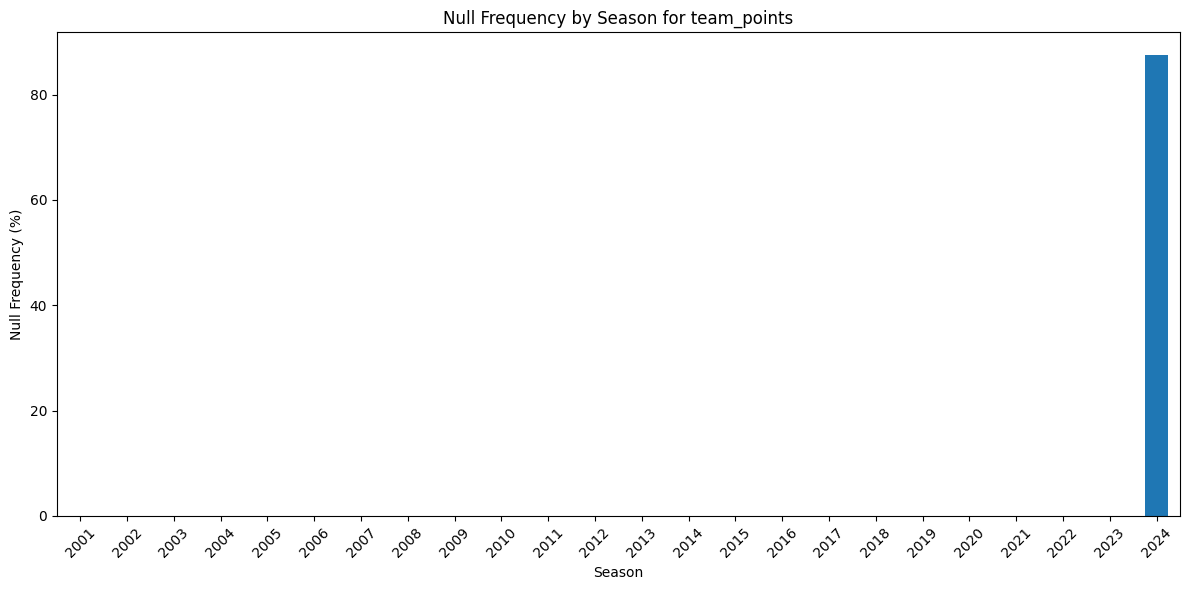

In [165]:
plot_null_frequency_by_season(processed_teams_df, ['team_elo_rating', 'team_score_fourth', 'team_points'])

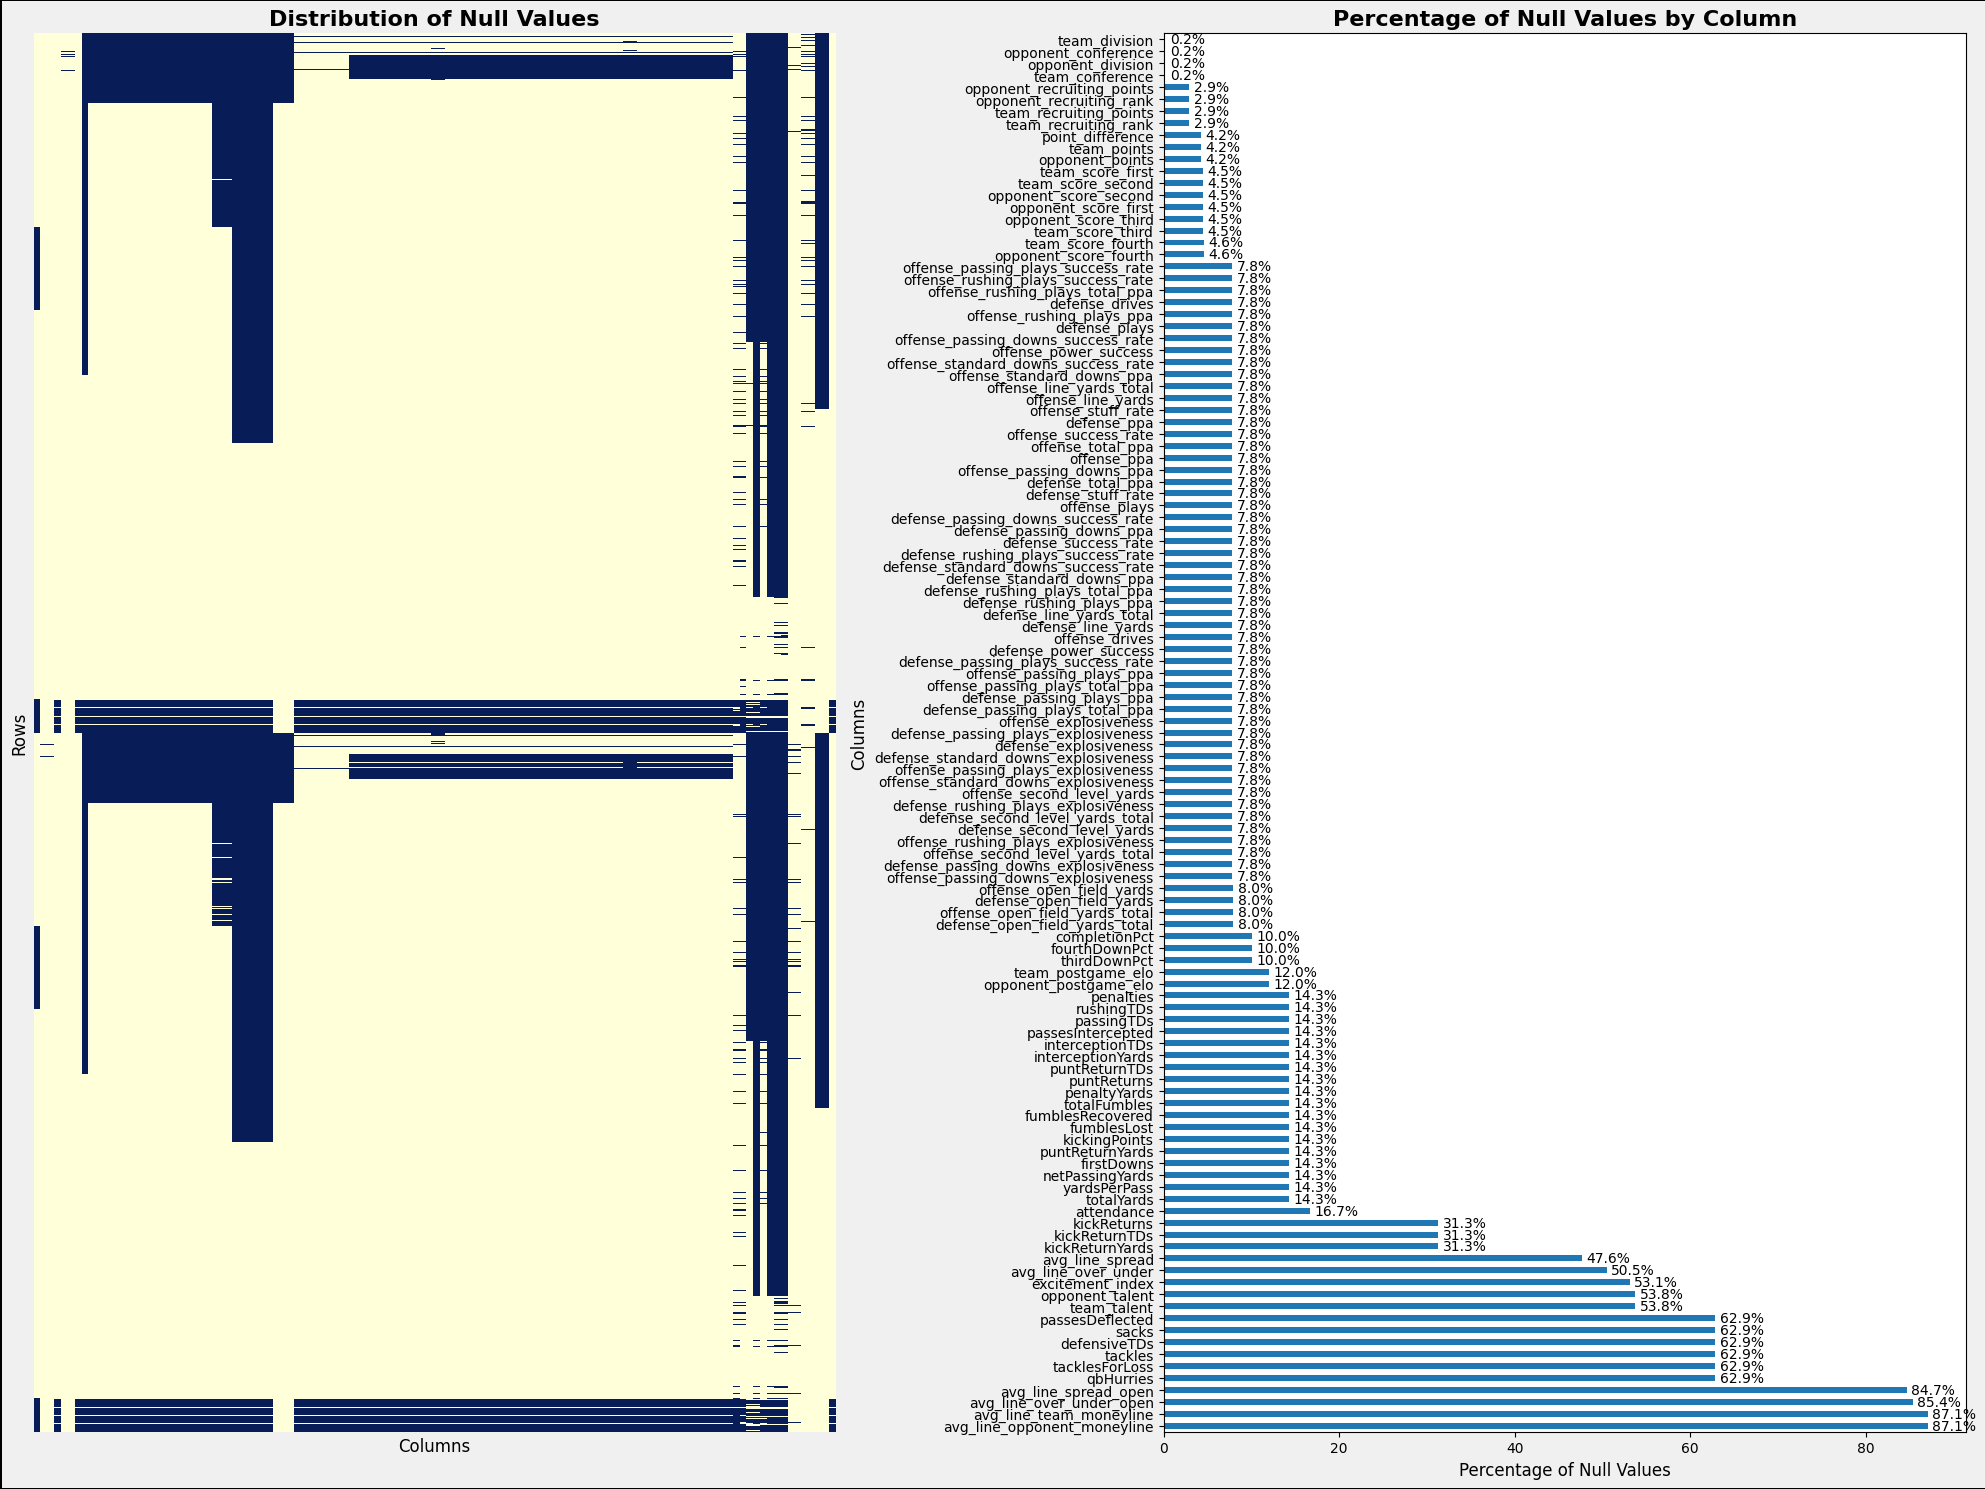

Columns with null values (sorted by percentage, descending):
avg_line_opponent_moneyline: 18063 null values (87.05%)
avg_line_team_moneyline: 18063 null values (87.05%)
avg_line_over_under_open: 17712 null values (85.36%)
avg_line_spread_open: 17572 null values (84.68%)
qbHurries: 13042 null values (62.85%)
tacklesForLoss: 13042 null values (62.85%)
tackles: 13042 null values (62.85%)
defensiveTDs: 13042 null values (62.85%)
sacks: 13042 null values (62.85%)
passesDeflected: 13042 null values (62.85%)
team_talent: 11154 null values (53.75%)
opponent_talent: 11154 null values (53.75%)
excitement_index: 11020 null values (53.11%)
avg_line_over_under: 10474 null values (50.48%)
avg_line_spread: 9884 null values (47.63%)
kickReturnYards: 6491 null values (31.28%)
kickReturnTDs: 6491 null values (31.28%)
kickReturns: 6491 null values (31.28%)
attendance: 3464 null values (16.69%)
totalYards: 2960 null values (14.27%)
yardsPerPass: 2960 null values (14.27%)
netPassingYards: 2960 null values 

In [169]:
visualize_null_values(processed_teams_df)

## Matchup and Target Variables

In [171]:
# Create a matchup column with team_id and opponent_id (not sorted)
cleaned_df['matchup'] = cleaned_df.apply(lambda row: (row['team_id'], row['opponent_id']), axis=1)

# Display the first few rows to verify the new column
print(cleaned_df[['team_id', 'opponent_id', 'matchup']].head())

# Display value counts to check the distribution
print("\nTop 10 most common matchups:")
print(cleaned_df['matchup'].value_counts().head(10))

# Ensure 'start_date' column exists and is in the correct format
if 'start_date' not in cleaned_df.columns:
    print("Warning: 'start_date' column is missing. This is required for calculate_team_vs_team_win_rate function.")
else:
    print("'start_date' column exists. Ensure it's in the correct datetime format.")

# Check if 'win' column exists
if 'win' not in cleaned_df.columns:
    print("Warning: 'win' column is missing. This is required for calculate_team_vs_team_win_rate function.")
else:
    print("'win' column exists.")

   team_id  opponent_id      matchup
0      238         2579  (238, 2579)
1        2         2433    (2, 2433)
2       61          290    (61, 290)
3      344         2655  (344, 2655)
4       99          204    (99, 204)

Top 10 most common matchups:
matchup
(228, 59)     21
(59, 228)     21
(103, 259)    21
(201, 251)    21
(259, 103)    21
(2, 61)       21
(251, 201)    21
(61, 2)       21
(197, 239)    20
(239, 201)    20
Name: count, dtype: int64
'start_date' column exists. Ensure it's in the correct datetime format.


In [172]:
# Create a 'win' column based on the 'result' column
cleaned_df['win'] = cleaned_df['result'].where(cleaned_df['result'] == 'win', 0)
cleaned_df['win'] = cleaned_df['win'].where(cleaned_df['win'] == 0, 1)

# Convert 'win' column to integer type
cleaned_df['win'] = cleaned_df['win'].astype(int)

# Display the first few rows to verify the new column
print(cleaned_df[['result', 'win']].head())

# Display value counts to check the distribution
print("\nValue counts for 'win' column:")
print(cleaned_df['win'].value_counts(normalize=True))

  result  win
0   loss    0
1    win    1
2    win    1
3    win    1
4    win    1

Value counts for 'win' column:
win
0    0.5
1    0.5
Name: proportion, dtype: float64


## Split into All Years and All Data

In [173]:
# Split cleaned_df into two DataFrames

# DataFrame with seasons 2016 and later
df_2016_plus = cleaned_df[cleaned_df['season'] >= 2016].copy()

# DataFrame with all seasons but specific columns dropped
columns_to_drop = [
    'tacklesForLoss', 'defensiveTDs', 'tackles', 'sacks', 'qbHurries',
    'passesDeflected', 'team_talent', 'opponent_talent', 'excitement_index',
    'kickReturnYards', 'kickReturnTDs', 'kickReturns', 'attendance'
]
df_all_years = cleaned_df.drop(columns=columns_to_drop)

# Print info about the resulting DataFrames
print("DataFrame with seasons 2016 and later:")
print(f"Shape: {df_2016_plus.shape}")
print(f"Seasons included: {df_2016_plus['season'].unique()}")
print("\nDataFrame with all seasons and specific columns dropped:")
print(f"Shape: {df_all_years.shape}")
print(f"Seasons included: {df_all_years['season'].unique()}")
print("Columns dropped:", columns_to_drop)

# Verify that the specified columns were dropped
remaining_columns = set(df_all_years.columns)
dropped_columns = set(columns_to_drop)
if not dropped_columns.issubset(cleaned_df.columns):
    print("\nWarning: Some specified columns were not in the original DataFrame.")
if dropped_columns.intersection(remaining_columns):
    print("\nWarning: Some specified columns were not dropped.")
else:
    print("\nAll specified columns were successfully dropped from df_all_years.")

DataFrame with seasons 2016 and later:
Shape: (7110, 121)
Seasons included: [2016 2017 2018 2019 2020 2021 2022 2023]

DataFrame with all seasons and specific columns dropped:
Shape: (16438, 108)
Seasons included: [2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2020 2021 2022 2023]
Columns dropped: ['tacklesForLoss', 'defensiveTDs', 'tackles', 'sacks', 'qbHurries', 'passesDeflected', 'team_talent', 'opponent_talent', 'excitement_index', 'kickReturnYards', 'kickReturnTDs', 'kickReturns', 'attendance']

All specified columns were successfully dropped from df_all_years.


## Save to Parquet

In [174]:
# Save df_2016_plus and df_all_years to root/data/02_interim

# Define the path for the interim data directory
interim_data_dir = os.path.join(project_root, 'data', '02_interim')

# Ensure the directory exists
os.makedirs(interim_data_dir, exist_ok=True)

# Save df_2016_plus as a Parquet file
df_2016_plus_path = os.path.join(interim_data_dir, 'df_2016_plus.parquet')
df_2016_plus.to_parquet(df_2016_plus_path, index=False)

# Save df_all_years as a Parquet file
df_all_years_path = os.path.join(interim_data_dir, 'df_all_years.parquet')
df_all_years.to_parquet(df_all_years_path, index=False)

print(f"df_2016_plus saved to: {df_2016_plus_path}")
print(f"df_all_years saved to: {df_all_years_path}")

df_2016_plus saved to: /Users/colingaffney/repos/personal-projects/college_football_predictor/data/02_interim/df_2016_plus.parquet
df_all_years saved to: /Users/colingaffney/repos/personal-projects/college_football_predictor/data/02_interim/df_all_years.parquet


## Team Pairs

In [155]:
team_pairs_file = generate_and_save_team_pairs(cleaned_df, project_root)
print(f"Team pairs saved to: {team_pairs_file}")


Team pairs saved to: /Users/colingaffney/repos/personal-projects/college_football_predictor/src/utils/team_pairs.py
